# Clasificador COVID-19

El problema a resolver es la clasificación de imágenes de muestras vísricas para detectar el virus *COVID-19*.

Esta prueba deberá ser capaz de reconocer si el paciente está infectado por algun virus de la familia *Coronaviridae*, que con mucha probabilidad, será el *COVID-19*.

In [30]:
import tensorflow as tf
import numpy as np
import os # Funciones del sistema operativo
from PIL import Image # Para obtener el valor de los pixeles de las imágenes
import matplotlib.pyplot as plt
import random as rng

## Datos

Se usará el 80% de los datos para entrenamiento, y el 20% restante para evaluar el modelo.

Los datos serán imágenes en blanco y negro de distintos tamaños, y estarán etiquetadas como **muestra vacía**, **otro virus** o ***COVID-19***.

In [2]:
IMG_SIZE = 500

In [3]:
className = ["blank", "other", "coronaviridae"]

Transformar las imágenes a blanco y negro puro, porque parece haber errores en las imágenes, y se detectan como RGB en lugar de escala de grises. También se va a definir un tamaño de **500x500**px.

Se dividen los datos en el set de entrenamiento y evaluación. 

In [4]:
trainingSet = []
evaluationSet = []

for folder in os.listdir('./images'):
    for i, img in enumerate(os.listdir('./images/' + folder)):
        imgClass = folder        
        path = os.path.join('./images/' + folder, img)
        imgData = Image.open(path)
        imgData = imgData.convert("L")
        imgData = imgData.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
        imgData = np.array(imgData)
        if i % 10 < 8:
            trainingSet.append((imgData, imgClass))
        else:
            evaluationSet.append((imgData, imgClass))       

In [5]:
print("Tamaño del set de entrenamiento: ", len(trainingSet))
print("Tamaño del set de evaluación: ", len(evaluationSet))

Tamaño del set de entrenamiento:  102
Tamaño del set de evaluación:  24


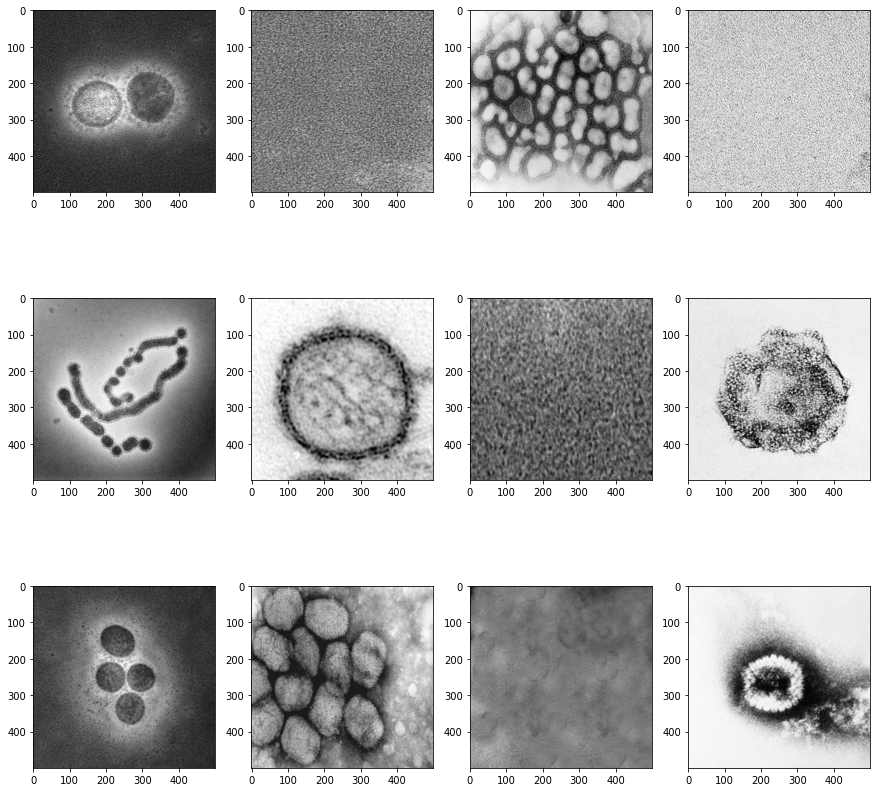

In [6]:
w=10
h=10
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    img = trainingSet[np.random.randint(len(trainingSet))][0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap = 'gist_gray')
plt.show()

Dado que el número de datos que se tienen es muy reducido, se va a optar por usar técnicas para aumentar el número de datos. Esto se hace para evitar el *overfitting*, dado que con un número pequeño de datos, es más fácil que se produzca.

El aumento de datos se realizará en todas las imágenes, para aumentar el máximo posible el número de datos. Para evitar una evaluación sesgada, no se evaluará con las imágenes nuevas creadas por el conjunto de entrenamiento, y no se entrenará con las imágenes nuevas creadas con el conjunto de evaluación.

Las técnicas de aumentos de datos que se van a utilzar son: **Rotación**, **volteo**, **añadir ruido** y **traslación**.

Otras técnicas que serían también útiles son: ampliar o alejar la imagen, rotaciones no solo de 90º y mezclar varias técnicas.

Estas técnicas se pueden aplicar a las imágenes debido a que no son especialmente simétricas, y por tanto, reducirán la probabilidad de que aparezca el *overfitting*.

Se van a realizar 3 volteos, 3 rotaciones, 4 traslaciones y 1 imagen con ruido. De forma que por cada imagen se crean 11 nuevas.

In [44]:
newTrainingSet = []

for data in trainingSet:
    newTrainingSet.append((np.flipud(data[0]), data[1])) #Volteo de arriba a abajo
    newTrainingSet.append((np.fliplr(data[0]), data[1])) #Volteo de izquierda a derecha
    newTrainingSet.append((np.flip(data[0], (0, 1)), data[1])) #Volteo de izquierda a derecha y de arriba a abajo 
    
    newTrainingSet.append((np.rot90(data[0]), data[1])) #Una rotación de 90º
    newTrainingSet.append((np.rot90(data[0], 2), data[1])) #Dos rotaciones de 90º
    newTrainingSet.append((np.rot90(data[0], 3), data[1])) #Tres rotaciones de 90º

    newImgDown = data[0].copy()
    newImgUp = data[0].copy()
    newImgLeft = data[0].copy()
    newImgRight = data[0].copy()
    
    newImgNoise = data[0].copy()

    for i in range(IMG_SIZE):
      for j in range(IMG_SIZE):
        newImgDown[i][j] = data[0][(i-200)%IMG_SIZE][j] #Traslación hacia abajo
        newImgUp[i][j] = data[0][(i+200)%IMG_SIZE][j] #Traslación hacia arriba
        newImgLeft[i][j] = data[0][i][(j+200)%IMG_SIZE] #Traslación hacia izquierda
        newImgRight[i][j] = data[0][i][(j-200)%IMG_SIZE] #Traslación hacia derecha
        
        
        noise = rng.randint(-150, 150)
        if noise + test[i][j] < 0:
            newImgNoise[i][j]=0
        elif noise + newImgNoise[i][j] > 255:
            newImgNoise[i][j]=255
        else:
            newImgNoise[i][j]+=noise


    
    newTrainingSet.append((newImgDown, data[1]))
    newTrainingSet.append((newImgUp, data[1]))
    newTrainingSet.append((newImgLeft, data[1]))
    newTrainingSet.append((newImgRight, data[1]))
    
    newTrainingSet.append((newImgNoise, data[1]))

trainingSet += newTrainingSet

In [45]:
rng.shuffle(trainingSet)

In [46]:
print("Tamaño del set de entrenamiento ampliado: ", len(trainingSet))

Tamaño del set de entrenamiento ampliado:  1224
